In [2]:
%load_ext autoreload
%autoreload 2
import torch
import torch.nn.functional as F
from torch import Tensor
from datetime import datetime
import math
import random
import numpy as NP
import matplotlib.pyplot as plt
%matplotlib inline
relPath = "../../"
import sys
sys.path.append(relPath)
from mm.printing import *
from network import *
from neural import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [127]:
initLogging("Common init")

dtype = torch.float
log("dtype", dtype)

dvc = torch.device("cpu")
log("device", dvc.type)

contextSize = 3
log("contextSize", contextSize)


Common init:         -------------------------- 2023-07-21 13:04:03
dtype:               torch.float32
device:              cpu
contextSize:         3


In [128]:
logSection("Prepare data")

filePath = relPath + "data/names.txt"
log("filePath", filePath)

trRatio = 0.8
log("trRatio", trRatio)

devRatio = 0.9
log("devRatio", devRatio)

wordShufflingSeed = 42
log("wordShufflingSeed", wordShufflingSeed)

words = readFileSplitByLine(filePath)
random.seed(wordShufflingSeed)
random.shuffle(words)
log("first few words", words[:5])

lenWords = len(words);
log("lenWords", lenWords)

allPossibleChars = sorted(list(set("".join(words))))
log("allPossibleChars", allPossibleChars)

stoi = sToI(allPossibleChars)
log("stoi", stoi)

itos = iToS(stoi)
log("itos", itos)

vocabularyLength = len(itos)
log("vocabularyLength", vocabularyLength)

log("data random probability", f"{-torch.tensor(1 / vocabularyLength).log().item():.4f}")


Prepare data:        -------------------------- 2023-07-21 13:04:03
filePath:            ../../../data/names.txt
trRatio:             0.8
devRatio:            0.9
wordShufflingSeed:   42
first few words:     ['yuheng', 'diondre', 'xavien', 'jori', 'juanluis']
lenWords:            32033
allPossibleChars:    ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
stoi:                {'.': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}
itos:                {0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}
vocabularyLength:    27
data random probability: 3.

In [129]:
logSection("Prepare dataset")

dataDtype = torch.int64
log("data dtype", dataDtype)

lenTrain = int(trRatio * lenWords)
trWords = words[:lenTrain]
trX, trY = buildDataSet(trWords, contextSize, stoi, itos, dataDtype, dvc)
log("data set training", lenTrain, trX.shape, trY.shape, trWords[:3])

endVal = int(devRatio * lenWords)
valWords = words[lenTrain:endVal];
valX, valY = buildDataSet(valWords, contextSize, stoi, itos, dataDtype, dvc)
log("data set validation", endVal - lenTrain, valX.shape, valY.shape, valWords[:3])

lenTest = lenWords - endVal
tstWords = words[endVal:]
tstX, tstY = buildDataSet(tstWords, contextSize, stoi, itos, dataDtype, dvc)
log("data set test", lenTest, tstX.shape, tstY.shape, tstWords[:3])

Prepare dataset:     -------------------------- 2023-07-21 13:04:03
data dtype:          torch.int64
data set training:   25626 torch.Size([182625, 3]) torch.Size([182625]) ['yuheng', 'diondre', 'xavien']
data set validation: 3203 torch.Size([22655, 3]) torch.Size([22655]) ['amay', 'aytana', 'jenevi']
data set test:       3204 torch.Size([22866, 3]) torch.Size([22866]) ['mustafa', 'reuben', 'kahlel']


In [130]:
logSection("Build network")

embeddingDims = 10
log("embeddingDims", embeddingDims)

hiddenLayerSize = 200
log("hiddenLayerSize", hiddenLayerSize)

learningSeed = 2147483647
log("learningSeed", learningSeed)
g = torch.Generator(device=dvc).manual_seed(learningSeed)

np = makeNetwork(g, vocabularyLength, embeddingDims, contextSize, hiddenLayerSize, dvc)
log("parametersCount", sum(p.nelement() for p in np.all))

@torch.no_grad()
def trLoss(): return getLoss(np, np.C[trX], trY)

@torch.no_grad()
def valLoss(): return getLoss(np, np.C[valX], valY)

@torch.no_grad()
def tstLoss(): return getLoss(np, np.C[tstX], tstY)

def getLosses() -> Losses:
    l = Losses()
    l.tr = trLoss()
    l.val = valLoss()
    l.tst = tstLoss()
    return l

def logLosses():
    losses = getLosses()
    l1 = f"{losses.tr.loss.item():>10.4f}"
    l2 = f"{losses.val.loss.item():>10.4f}"
    l3 = f"{losses.tst.loss.item():>10.4f}"
    logSimple(f"{l1} {l2} {l3}")

Build network:       -------------------------- 2023-07-21 13:04:04
embeddingDims:       10
hiddenLayerSize:     200
learningSeed:        2147483647
W1ratio:             0.19
b1ratio:             0.01
W2ratio:             0.1
b2ratio:             0
parametersCount:     11897


Learning:            -------------------------- 2023-07-21 13:04:04
trainingBatchSize:   32
trainingSteps: :     5708
maxIteration:        200000
repeats:             36
maxLr:               0.14
minLr:               0.0001
actualIterations:    200000
  0,      0 losses:     0.0000       3.6881     3.6869     3.6884
  1,   5708 losses:     2.1539       2.2850     2.2981     2.2947
  2,  11416 losses:     2.2996       2.2470     2.2635     2.2585
  3,  17124 losses:     2.0328       2.2301     2.2506     2.2447
  4,  22832 losses:     2.0851       2.2037     2.2293     2.2302
  5,  28540 losses:     2.3046       2.1964     2.2312     2.2206
  6,  34248 losses:     2.0116       2.1770     2.2127     2.2086
  7,  39956 losses:     2.3696       2.1526     2.1974     2.1858
  8,  45664 losses:     1.8854       2.1530     2.1917     2.1920
  9,  51372 losses:     2.2234       2.1581     2.1974     2.2009
 10,  57080 losses:     2.2198       2.1531     2.1963     2.1934
 11,  62788 losses:   

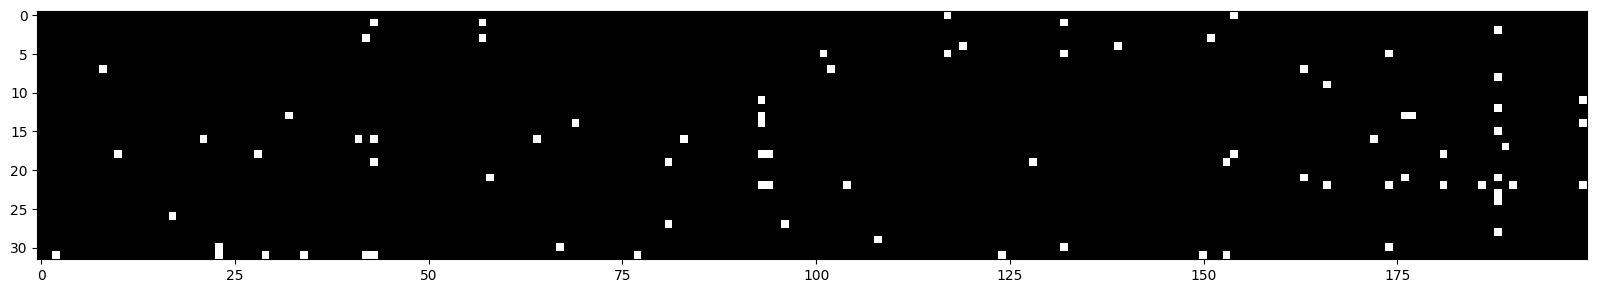

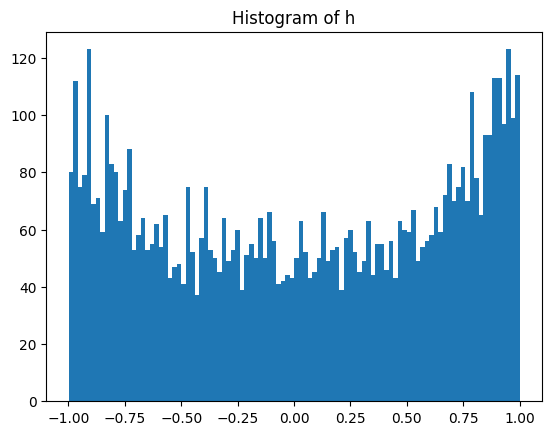

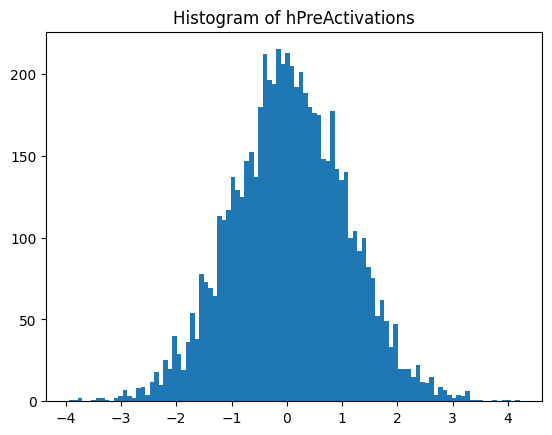

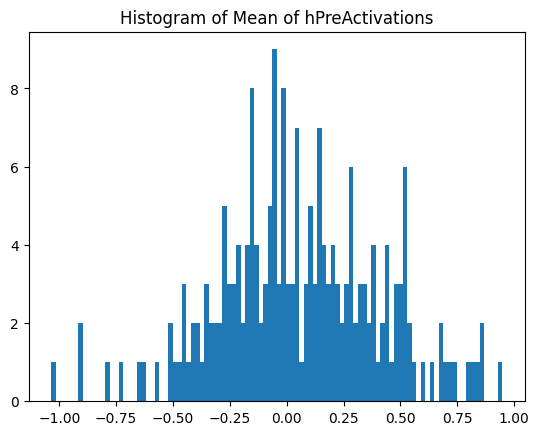

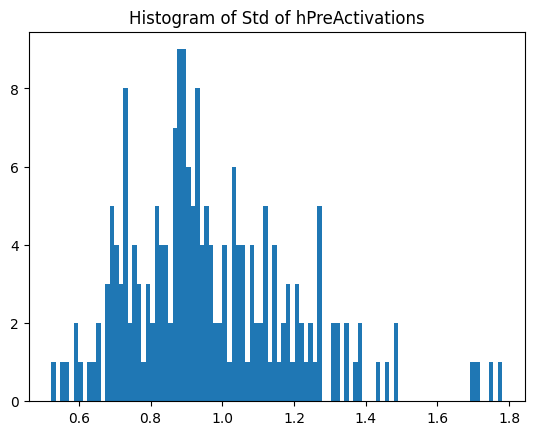

In [131]:
logSection("Learning")

trainingBatchSize = 32
log("trainingBatchSize", trainingBatchSize)

trXLength = trX.shape[0]
trainingSteps = (trXLength // trainingBatchSize) + 1
log ("trainingSteps: ", trainingSteps)

maxIteration = 200_000
log("maxIteration", maxIteration)

repeats = 36
log("repeats",repeats)

maxLr = 0.14
log("maxLr", maxLr)

minLr = 0.0001
log("minLr", minLr)

actualIterations = min(maxIteration, repeats * math.ceil(trXLength / trainingBatchSize))
log("actualIterations", actualIterations)

lrAtIx: list[float] = []
stepIx: list[int] = []
lossAtIx: list[float] = []
logLossAtIx: list[float] = []
up = UpdateNetResult()
fr = ForwardPassResult()
fr.loss = torch.tensor(0)
i = 0
lr = 0.1;
lre = torch.linspace(-3, 0, trainingSteps)
lrs = 10 ** lre

for repeat in range(repeats):
    
    if i >= maxIteration:
        break;

    logSimple(f"{repeat:>3}, {i:>6} losses: {fr.loss.item():>10.4f}   ", end="")
    logLosses()

    for start in range(0, trXLength, trainingBatchSize):

        if i >= maxIteration:
            log("Break at max iteration")
            break;
        
        end = min(start + trainingBatchSize, trXLength)
        #miniBatchIxs = torch.arange(start, end)
        miniBatchIxs = torch.randint(0, trXLength, (trainingBatchSize,), generator=g, device=dvc)
        fr = forwardPass(np, trX, trY, miniBatchIxs)
        backwardPass(np.all, fr.loss)

        if i == 1:
            plt.figure(figsize=(20, 10))
            plt.imshow(fr.h.abs() > 0.99, cmap="gray", interpolation="nearest")
            
            plt.figure()
            plt.hist(fr.h.view(-1).tolist(), 100)
            plt.title('Histogram of h')

            plt.figure()
            plt.hist(fr.hPreActivations.view(-1).tolist(), 100)
            plt.title('Histogram of hPreActivations')

            plt.figure()
            plt.hist(fr.hPreActivations.mean(0, keepdim=True).view(-1).tolist(), 100)
            plt.title('Histogram of Mean of hPreActivations')

            plt.figure()
            plt.hist(fr.hPreActivations.std(0, keepdim=True).view(-1).tolist(), 100)
            plt.title('Histogram of Std of hPreActivations')

        up = updateNet(np.all, i, actualIterations, maxLr, minLr)
        lrAtIx.append(up.learningRate)

        stepIx.append(i)
        lossAtIx.append(fr.loss.item())
        logLossAtIx.append(fr.loss.log10().item())

        #lr = lrs[i].item()
        #lrAtIx.append(lrs[i].item())
        
        i += 1

logSimple(f" final losses: {fr.loss.item():>15.4f}   ", end="")
logLosses()

#bestLr = lrs[findLowestIndex(lossAtIx)].item();
#log("best learning rate", bestLr)
log("emb.shape", fr.emb.shape)
#log("h.shape", fr.h.shape)
log("logits.shape", fr.logits.shape)

In [132]:
logSection("Sampling")

samplingSeed = learningSeed + 10
gSampling = torch.Generator(device=dvc).manual_seed(samplingSeed)
log("samplingSeed", samplingSeed)

maxSampleLength = 50
log("maxSampleLength", maxSampleLength)

Sampling:            -------------------------- 2023-07-21 13:07:01
samplingSeed:        2147483657
maxSampleLength:     50


In [133]:
samples = sampleMany(np, gSampling, contextSize, itos, 20, maxSampleLength)
for s in samples:
    logSimple(f"{''.join(s.values):<21}{(s.prob * 10000):>4.0f}: ", end="")
    for p in s.probs:
        logSimple(f"{(p / (1 / 27) * 10):.0f} ", end="")
    logSimple()

bria.                 140: 11 140 59 20 137 
kmyah.                100: 35 1 10 3 57 255 
keel.                 246: 35 49 7 76 49 
ndhayla.               12: 3 1 7 44 11 84 79 137 
quince.               358: 21 208 85 150 36 120 168 
brerlee.               64: 11 140 53 1 6 107 59 173 
fieredieli.           176: 36 84 17 59 17 3 39 29 62 16 67 
jemilopaleigh.         77: 11 48 12 176 115 26 3 36 18 14 51 172 229 206 
van.                  131: 7 101 117 104 
xareem.               109: 12 79 20 62 83 14 190 
zios.                  53: 5 70 26 19 190 
karin.                303: 35 110 43 81 10 61 
sadhvoghairiel.        36: 9 50 13 16 25 24 1 98 155 4 20 34 15 90 138 
kinde.                220: 35 38 74 19 42 15 
jennex.               114: 11 48 53 80 108 14 173 
teriffuntin.           69: 9 64 54 55 2 171 7 65 54 113 86 174 
der.                   77: 8 89 10 133 
jaquizeks.             59: 11 105 14 223 99 8 40 9 6 63 
kaeshawn.             435: 35 110 12 58 45 174 57 171 241 
lavihaa

In [134]:
def printProb(txt: str):
    ps = calcProb(np, txt, contextSize, stoi)
    op = calcOneProb(ps)
    logSimple(f"{txt:<21}{(op * 10000):<7.0f}: ", end="")
    for p in ps:
        logSimple(f"{(p / (1 / 27) * 10):.0f} ", end="")
    logSimple()

printProb('.')
printProb('m.')
printProb('mi.')
printProb('mic.')
printProb('mich.')
printProb('micha.')
printProb('michal.')
printProb('michael.')
printProb('michaela.')
printProb('michaella.')
printProb('michel.')
printProb('michalx.')
printProb('michalxx.')
printProb('michalxxx.')
printProb('martin.')
printProb('andrej.')
printProb('andrey.')
printProb('joey.')
printProb('james.')
printProb('xin.')
printProb('maxim.')
printProb('alex.')
printProb('alexa.')

.                    1      : 0 
m.                   1      : 7 0 
mi.                  12     : 7 78 0 
mic.                 50     : 7 78 44 10 
mich.                72     : 7 78 44 101 34 
micha.               60     : 7 78 44 101 107 9 
michal.              50     : 7 78 44 101 107 7 23 
michael.             68     : 7 78 44 101 107 13 179 47 
michaela.            71     : 7 78 44 101 107 13 179 39 133 
michaella.           69     : 7 78 44 101 107 13 179 19 82 194 
michel.              67     : 7 78 44 101 44 62 51 
michalx.             12     : 7 78 44 101 107 7 0 8 
michalxx.            13     : 7 78 44 101 107 7 0 1 190 
michalxxx.           7      : 7 78 44 101 107 7 0 1 0 23 
martin.              58     : 7 111 64 3 50 100 174 
andrej.              22     : 4 47 26 41 82 1 77 
andrey.              34     : 4 47 26 41 82 20 106 
joey.                97     : 11 53 29 13 197 
james.               96     : 11 105 22 39 31 89 
xin.                 126    : 12 60 25 85 
maxim.  

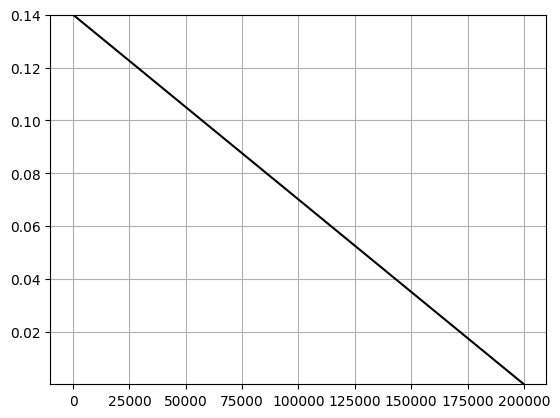

Actual min max LR 0.14 0.0001006994999999955


In [135]:
plt.plot(range(len(lrAtIx)), lrAtIx, "black")
plt.ylim(min(lrAtIx), max(lrAtIx))
plt.grid(True)
plt.show()
print("Actual min max LR", max(lrAtIx), min(lrAtIx))

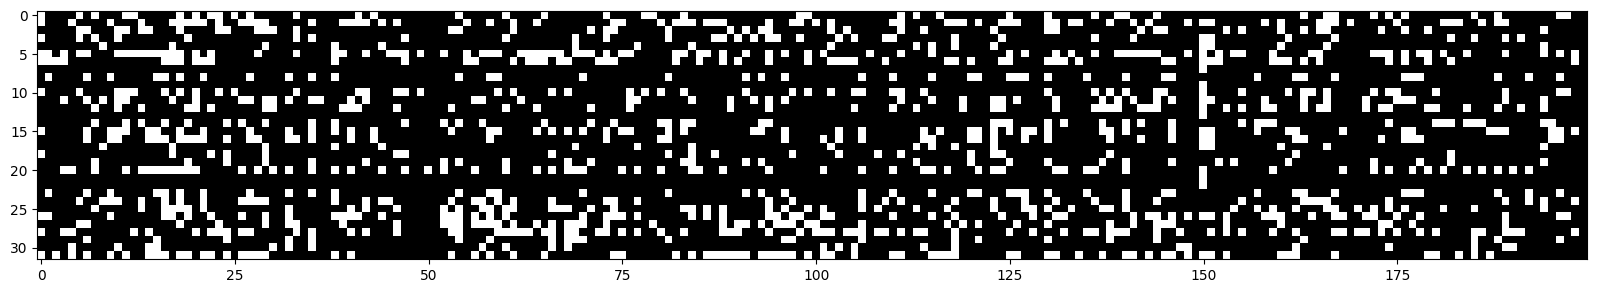

In [136]:
plt.figure(figsize=(20,10))
plt.imshow(fr.h.abs() > 0.99, cmap="gray", interpolation="nearest")

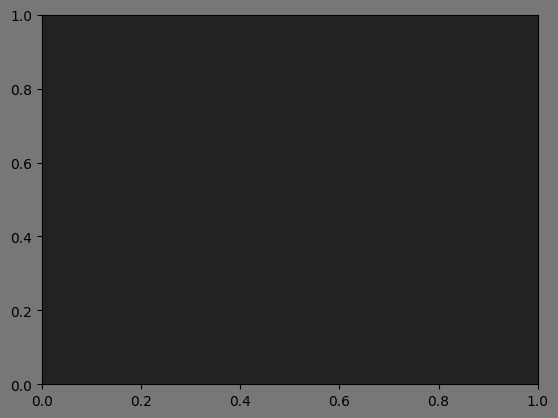

In [137]:
fig, ax = plt.subplots()
fig.set_facecolor("#777777")
ax.set_facecolor("#222222")
#ax.plot(lrAtIx, lossAtIx)
plt.show()

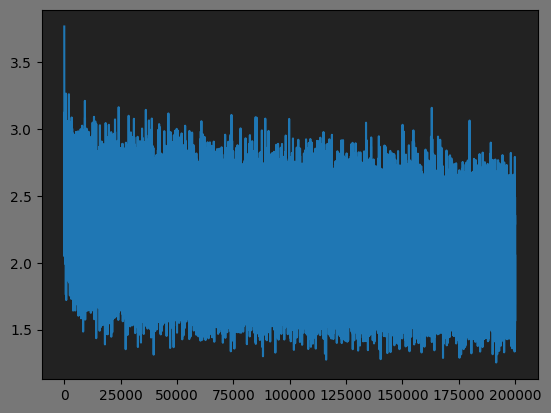

In [138]:
fig, ax = plt.subplots()
fig.set_facecolor("#777777")
ax.set_facecolor("#222222")
ax.plot(stepIx, lossAtIx)
plt.show()

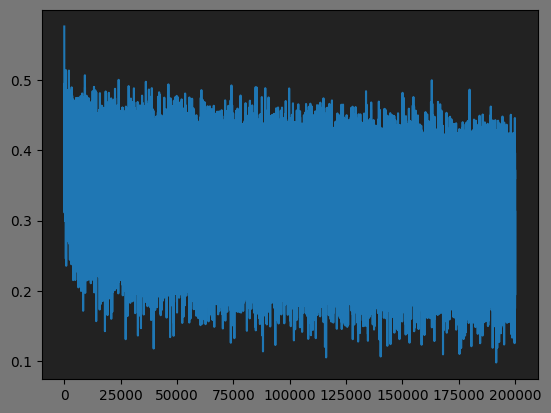

In [139]:
fig, ax = plt.subplots()
fig.set_facecolor("#777777")
ax.set_facecolor("#222222")
ax.plot(stepIx, logLossAtIx)
plt.show()

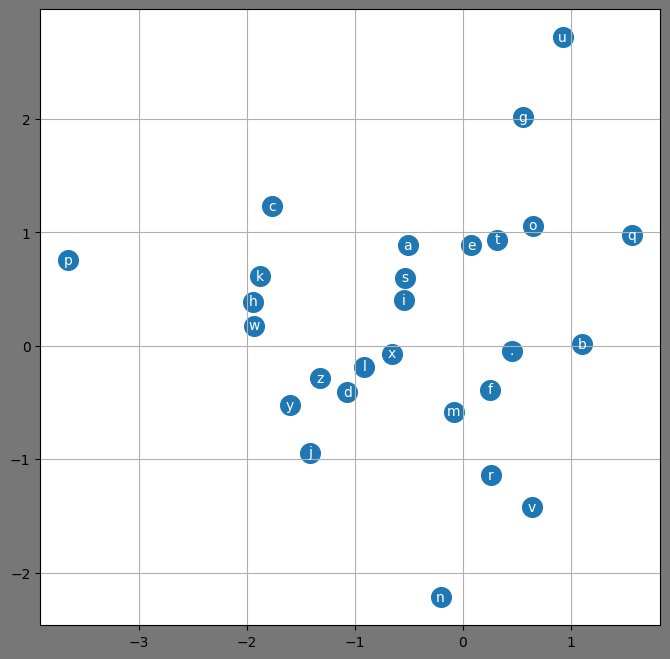

In [140]:
dim = 0
fig = plt.figure(figsize=(8,8))
fig.set_facecolor("#777777")
sc = plt.scatter(np.C[:, dim].data, np.C[:,dim + 1].data, s=200)
for i in range(np.C.shape[0]):
    plt.text(np.C[i, dim].item(), np.C[i, dim + 1].item(), itos[i], ha="center", va="center", color="white")
plt.grid()

In [141]:
#np.C.shape, trX.shape, np.C[trX].shape, np.C[:5], trX[:5], np.C[trX][:5]

In [142]:
# Let"s suppose these are your lists
C = [
[ 0.8774, -0.6801],
         [ 0.1651, -0.5025],
         [ 0.2769, -0.3570],
         [-0.8820,  0.3902],
         [-0.4824,  0.8744],
         [-0.3190,  0.7807],
         [-0.0100, -0.3401],
         [ 0.9975,  2.8280],
         [ 0.9623, -1.3172],
         [ 0.2180, -0.3820],
         [ 0.6139, -0.4287],
         [-0.7386,  0.5880],
         [-0.3088,  0.9816],
         [ 0.3907, -0.4174],
         [-0.7380,  0.5205],
         [-0.5288,  0.7074],
         [-0.3956,  0.9625],
         [-0.3802, -0.3504],
         [-0.2861,  0.7589],
         [ 0.5309, -0.5105],
         [-0.0922, -0.6410],
         [-0.3823,  0.9899],
         [ 0.0965, -0.5708],
         [-0.8582, -1.3429],
         [-0.4960,  0.2842],
         [-0.6105,  0.1336],
         [-0.2623,  0.2942]
]
trX = [
    [0, 0, 0],
    [0, 0, 22],
    [0, 22, 9],
    [22, 9, 15],
    [9, 15, 12],
    # ... More values
]

# We create a new list to hold the result
result = []

# We loop over each element in trX
for i in range(len(trX)):
    temp = []
    # Then we loop over each value in the element
    for j in range(len(trX[i])):
        # We use the value as an index to get the corresponding data from C
        temp.append(C[trX[i][j]])
    # We add the result to our new list
    result.append(temp)

# Let"s log the first 5 elements of the result list
for i in range(5):
    print(result[i])

[[0.8774, -0.6801], [0.8774, -0.6801], [0.8774, -0.6801]]
[[0.8774, -0.6801], [0.8774, -0.6801], [0.0965, -0.5708]]
[[0.8774, -0.6801], [0.0965, -0.5708], [0.218, -0.382]]
[[0.0965, -0.5708], [0.218, -0.382], [-0.5288, 0.7074]]
[[0.218, -0.382], [-0.5288, 0.7074], [-0.3088, 0.9816]]
